In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

    
import torch
import cv2  # For image loading
from PIL import Image
from ultralytics import Drone, FastSAM #or from your project import Drone
import numpy as np

Using GPU: Quadro P3200


In [19]:
#model = FastSAM("FastSAM-s.pt")
model = Drone("yolo11s-seg.pt")
if device == 'cuda':
    model = model.to(device)

image_path = "drone.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

with torch.no_grad():
    results = model(image)



Call Stack:
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 112
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\m

In [20]:
feature_maps = {}
prototypes = []

# Hook functions
def get_features(name):
    def hook(model, input, output):
        feature_maps[name] = output
    return hook

def get_prototypes(model, input, output):
    prototypes.append(output.detach())

# Register hooks
model.model.model[4].register_forward_hook(get_features('p3'))
model.model.model[6].register_forward_hook(get_features('p4'))
model.model.model[10].register_forward_hook(get_features('p5'))
model.model.model[16].register_forward_hook(get_features('sum_up'))  # this is concatenation after FPN
model.model.model[19].register_forward_hook(get_features('sum_mid'))
model.model.model[22].register_forward_hook(get_features('sum_down'))
model.model.model[23].proto.register_forward_hook(get_prototypes)

# Example input
model(image)

# Access the feature maps and prototypes
p3 = feature_maps['p3']
p4 = feature_maps['p4']
p5 = feature_maps['p5']
sum_up = feature_maps['sum_up']
sum_mid = feature_maps['sum_mid']
sum_down = feature_maps['sum_down']

proto = prototypes[0]

print(f"P3 shape: {p3.shape}")
print(f"P4 shape: {p4.shape}")
print(f"P5 shape: {p5.shape}")
print(f"sum_up shape: {sum_up.shape}")
print(f"sum_mid shape: {sum_mid.shape}")
print(f"sum_down shape: {sum_down.shape}")
print(f"Prototypes shape: {proto.shape}")


Call Stack:
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: inner, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1790
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1844
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: e:\ml\ultralytics\ultralytics

In [8]:
import torch.nn as nn

conv1x1 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, stride=1, padding=0)
conv1x1 = conv1x1.cuda()
sum_up_cloned = sum_up.clone()
output = conv1x1(sum_up_cloned)
print("Output shape:", output.shape)



Output shape: torch.Size([1, 32, 48, 80])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_heatmaps(feature_maps, layer_name, channel_figsize=(4, 3), combined_figsize=(8, 6), max_cols=8):
    """Visualizes heatmaps with separate size control for channels and combined.

    Args:
        feature_maps: The feature maps tensor (B, C, H, W).
        layer_name: The name of the layer.
        channel_figsize: Size of individual channel heatmaps (width, height).
        combined_figsize: Size of the combined heatmap (width, height).
        max_cols: Maximum number of columns in the subplot grid for channels.
    """
    batch_size, num_channels, height, width = feature_maps.shape

    # Channel Heatmaps
    num_cols = min(num_channels, max_cols)
    num_rows = (num_channels + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(channel_figsize[0] * num_cols, channel_figsize[1] * num_rows))
    fig.suptitle(f"Heatmaps per Channel - {layer_name}")

    for i in range(num_channels):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        heatmap = feature_maps[0, i].detach().cpu().numpy()
        im = ax.imshow(heatmap, cmap="viridis")
        ax.set_title(f"Channel {i+1}", fontsize=8)  # Smaller font for titles
        ax.axis('off')

    # Hide unused subplots
    for i in range(num_channels, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Combined Heatmap
    combined_heatmap = torch.sum(feature_maps, dim=1).squeeze().detach().cpu().numpy()
    plt.figure(figsize=combined_figsize)  # Use separate figsize
    plt.imshow(combined_heatmap, cmap="viridis")
    plt.title(f"Combined Heatmap - {layer_name}")
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [ ]:
p3 = feature_maps['p3']
p4 = feature_maps['p4']
p5 = feature_maps['p5']
sum_up = feature_maps['sum_up']
sum_mid = feature_maps['sum_mid']
sum_down = feature_maps['sum_down']
proto = prototypes[0]

# Visualize heatmaps for each layer
#visualize_heatmaps(p3, "P3")
visualize_heatmaps(sum_up, "sum_up")

#visualize_heatmaps(p4, "P4")
visualize_heatmaps(sum_mid, "sum_mid")

#visualize_heatmaps(p5, "P5")
visualize_heatmaps(sum_down, "sum_down")

#Visualize prototypes
visualize_heatmaps(proto, "Prototypes")

In [7]:
for result in results:
    print(result.boxes)  # Print detection boxes
    result.show()

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 7., 2., 0., 2., 2., 2.], device='cuda:0')
conf: tensor([0.8766, 0.8447, 0.8344, 0.8097, 0.7868, 0.7816, 0.7606, 0.7209, 0.6827, 0.6677, 0.6217, 0.5869, 0.5014, 0.4853, 0.4745, 0.3606, 0.3561, 0.3541, 0.3311, 0.3198, 0.3136, 0.3025, 0.3012, 0.2968, 0.2923, 0.2767, 0.2612, 0.2576], device='cuda:0')
data: tensor([[1.2058e+03, 7.7577e+02, 1.3456e+03, 8.7338e+02, 8.7661e-01, 2.0000e+00],
        [9.2315e+02, 9.2809e+02, 1.0680e+03, 1.0410e+03, 8.4473e-01, 2.0000e+00],
        [8.0506e+02, 8.1428e+02, 9.5958e+02, 9.2908e+02, 8.3435e-01, 2.0000e+00],
        [8.5769e+02, 8.6420e+02, 1.0190e+03, 9.8309e+02, 8.0966e-01, 2.0000e+00],
        [1.2628e+03, 8.3826e+02, 1.4053e+03, 9.5323e+02, 7.8684e-01, 2.0000e+00],
        [7.5440e+02, 5.3180e+02, 8.3260e+02, 6.1567e+02, 7.8160e-01, 2.0000e+00],
        [1.1563e+03, 7.0759e+02, 1.2913e+03, 

AttributeError: 'list' object has no attribute 'boxes'

In [7]:
preds = results[-2]

In [18]:
results[0].names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [8]:
num_classes=len(results[0].names)

In [10]:
prediction = results[-2][0]
bs = prediction.shape[0]  # batch size (BCN, i.e. 1,84,6300)
num_classes = num_classes or (prediction.shape[1] - 4)  # number of classes
nm = prediction.shape[1] - num_classes - 4

print(bs, num_classes, nm)

1 80 32


In [11]:
predictions = results[-2][0]  # Shape: [1, 116, 6300]

# Remove the batch dimension
predictions = predictions.squeeze(0)  # Shape: [116, 6300]

# Define the number of classes (e.g., 80 for COCO dataset)
num_classes = 80

# Extract bounding boxes (first 4 rows)
bounding_boxes = predictions[:4, :]  # Shape: [4, 6300]

# Extract objectness scores (5th row)
objectness_scores = predictions[4, :]  # Shape: [6300]

# Extract class probabilities (next `num_classes` rows)
class_probabilities = predictions[5:5 + num_classes, :]  # Shape: [80, 6300]

# Extract mask coefficients (remaining rows)
mask_coefficients = predictions[5 + num_classes:, :]  # Shape: [31, 6300] (if 116 - 4 - 1 - 80 = 31)

# Optional: Convert to NumPy for further processing
bounding_boxes = bounding_boxes.cpu().numpy()
objectness_scores = objectness_scores.cpu().numpy()
class_probabilities = class_probabilities.cpu().numpy()
mask_coefficients = mask_coefficients.cpu().numpy()

# Print shapes to verify
print(f"Bounding Boxes Shape: {bounding_boxes.shape}")  # Should be [4, 6300]
print(f"Objectness Scores Shape: {objectness_scores.shape}")  # Should be [6300]
print(f"Class Probabilities Shape: {class_probabilities.shape}")  # Should be [80, 6300]
print(f"Mask Coefficients Shape: {mask_coefficients.shape}")  # Should be [31, 6300]

Bounding Boxes Shape: (4, 5040)
Objectness Scores Shape: (5040,)
Class Probabilities Shape: (80, 5040)
Mask Coefficients Shape: (31, 5040)


In [14]:
len(results)

3

In [12]:
for img_idx, detections in enumerate(results[-1]):
    print(f"Image {img_idx + 1}:")
    
    #if detections.numel() == 0:
    #    print("  No detections.")
    #    continue

    # Columns of detections
    bounding_boxes = detections[:, :4]  # x1, y1, x2, y2
    objectness_scores = detections[:, 4]  # Confidence scores
    class_probabilities = detections[:, 5].long()  # Class index (not probabilities)
    mask_coefficients = detections[:, 6:]  # Mask coefficients

    # Print shapes
    print(f"  Bounding Boxes Shape: {bounding_boxes.shape}")  # [num_detections, 4]
    print(f"  Objectness Scores Shape: {objectness_scores.shape}")  # [num_detections]
    print(f"  Class Probabilities Shape: {class_probabilities.shape}")  # [num_detections]
    print(f"  Mask Coefficients Shape: {mask_coefficients.shape}")  # [num_detections, num_masks]

    # Optional: Number of detections
    print(f"  Number of Detections: {detections.shape[0]}")


Image 1:
  Bounding Boxes Shape: torch.Size([28, 4])
  Objectness Scores Shape: torch.Size([28])
  Class Probabilities Shape: torch.Size([28])
  Mask Coefficients Shape: torch.Size([28, 32])
  Number of Detections: 28


In [23]:
mask_coefficients

tensor([[ 0.3060,  0.0898,  0.0856,  1.0735,  0.3583, -0.2152,  0.0379, -1.5938, -0.6824, -0.3467, -1.7146, -0.7988,  0.1488, -0.9450, -0.4229, -0.0504,  0.5065,  0.0627, -0.5057, -0.0106,  0.0555,  0.8111,  0.0540,  0.0621, -0.7932, -0.6470,  0.1333,  0.1572,  0.1157, -1.7227,  0.3257,  0.8667]], device='cuda:0')

In [19]:
preds = results[-2]
if isinstance(preds[1], tuple):
    print("preds[1][-1]")
proto = preds[1][-1] if isinstance(preds[1], tuple) else preds[1]
proto.shape

preds[1][-1]


torch.Size([1, 32, 96, 160])

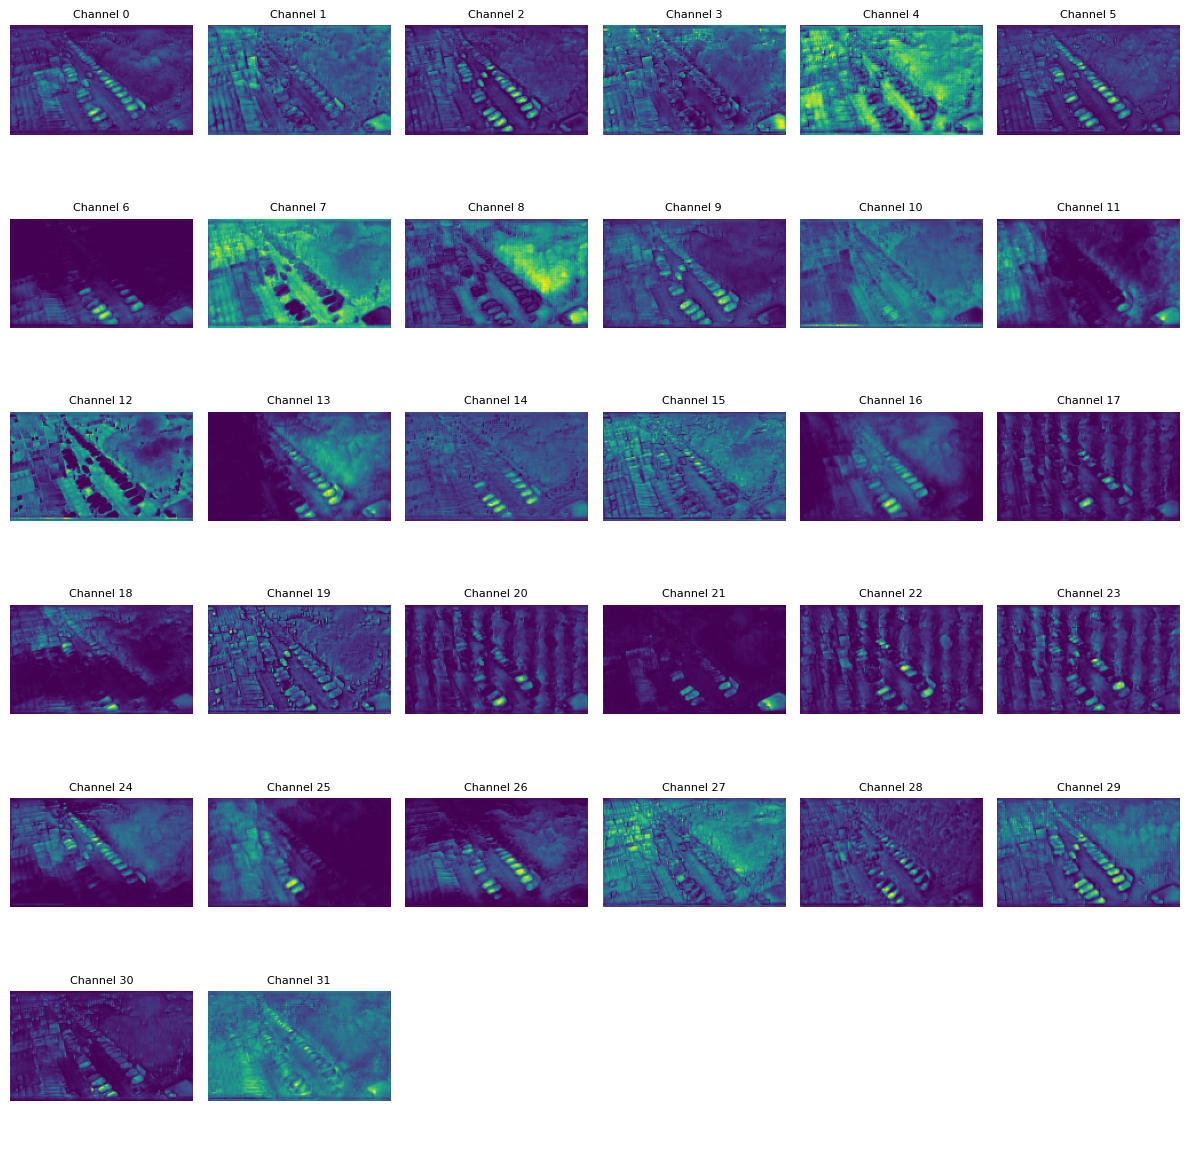

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np


# Remove batch dimension if present
if proto.ndim == 4:
    proto = proto.squeeze(0)

# Convert to NumPy array
if isinstance(proto, torch.Tensor):
    proto = proto.cpu().numpy()

# Determine grid dimensions
num_channels = proto.shape[0]
rows = int(np.ceil(np.sqrt(num_channels)))
cols = int(np.ceil(num_channels / rows))

# Create the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))  # Adjust size as needed

# Plot each channel in its respective grid cell
for i in range(num_channels):
    ax = axes[i // cols, i % cols]  # Determine subplot position
    ax.imshow(proto[i], cmap='viridis')  # Display with 'viridis' colormap
    ax.set_title(f"Channel {i}", fontsize=8)
    ax.axis('off')  # Turn off axes for a cleaner look

# Hide any unused subplots
for i in range(num_channels, rows * cols):
    axes[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()


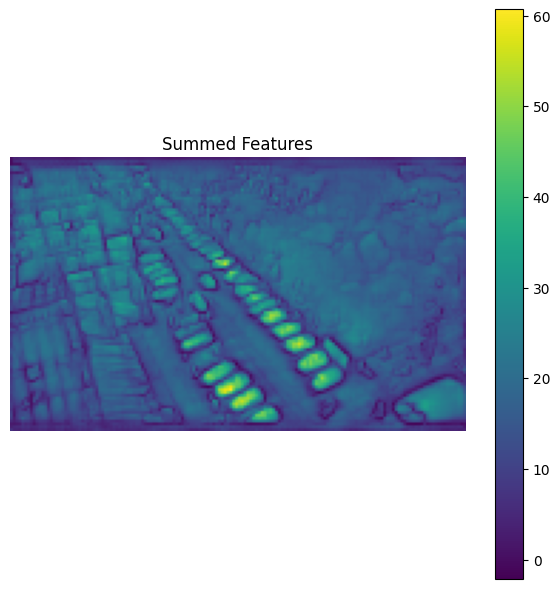

In [22]:
import matplotlib.pyplot as plt

# Step 1: Sum across the channels (dim=1) to reduce the channel dimension
summed_features = proto.sum(dim=1)  # Shape: [30, 40] after summing over channels
summed_features = summed_features.squeeze(0)
# Step 2: Visualize the summed features
fig, ax = plt.subplots(figsize=(6, 6))

# Summed Features
ax.imshow(summed_features.detach().cpu().numpy(), cmap='viridis')
ax.set_title("Summed Features")
ax.axis('off')

# Add colorbar to the plot
plt.colorbar(ax.imshow(summed_features.cpu().numpy(), cmap='viridis'), ax=ax)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


(28, 384, 640)


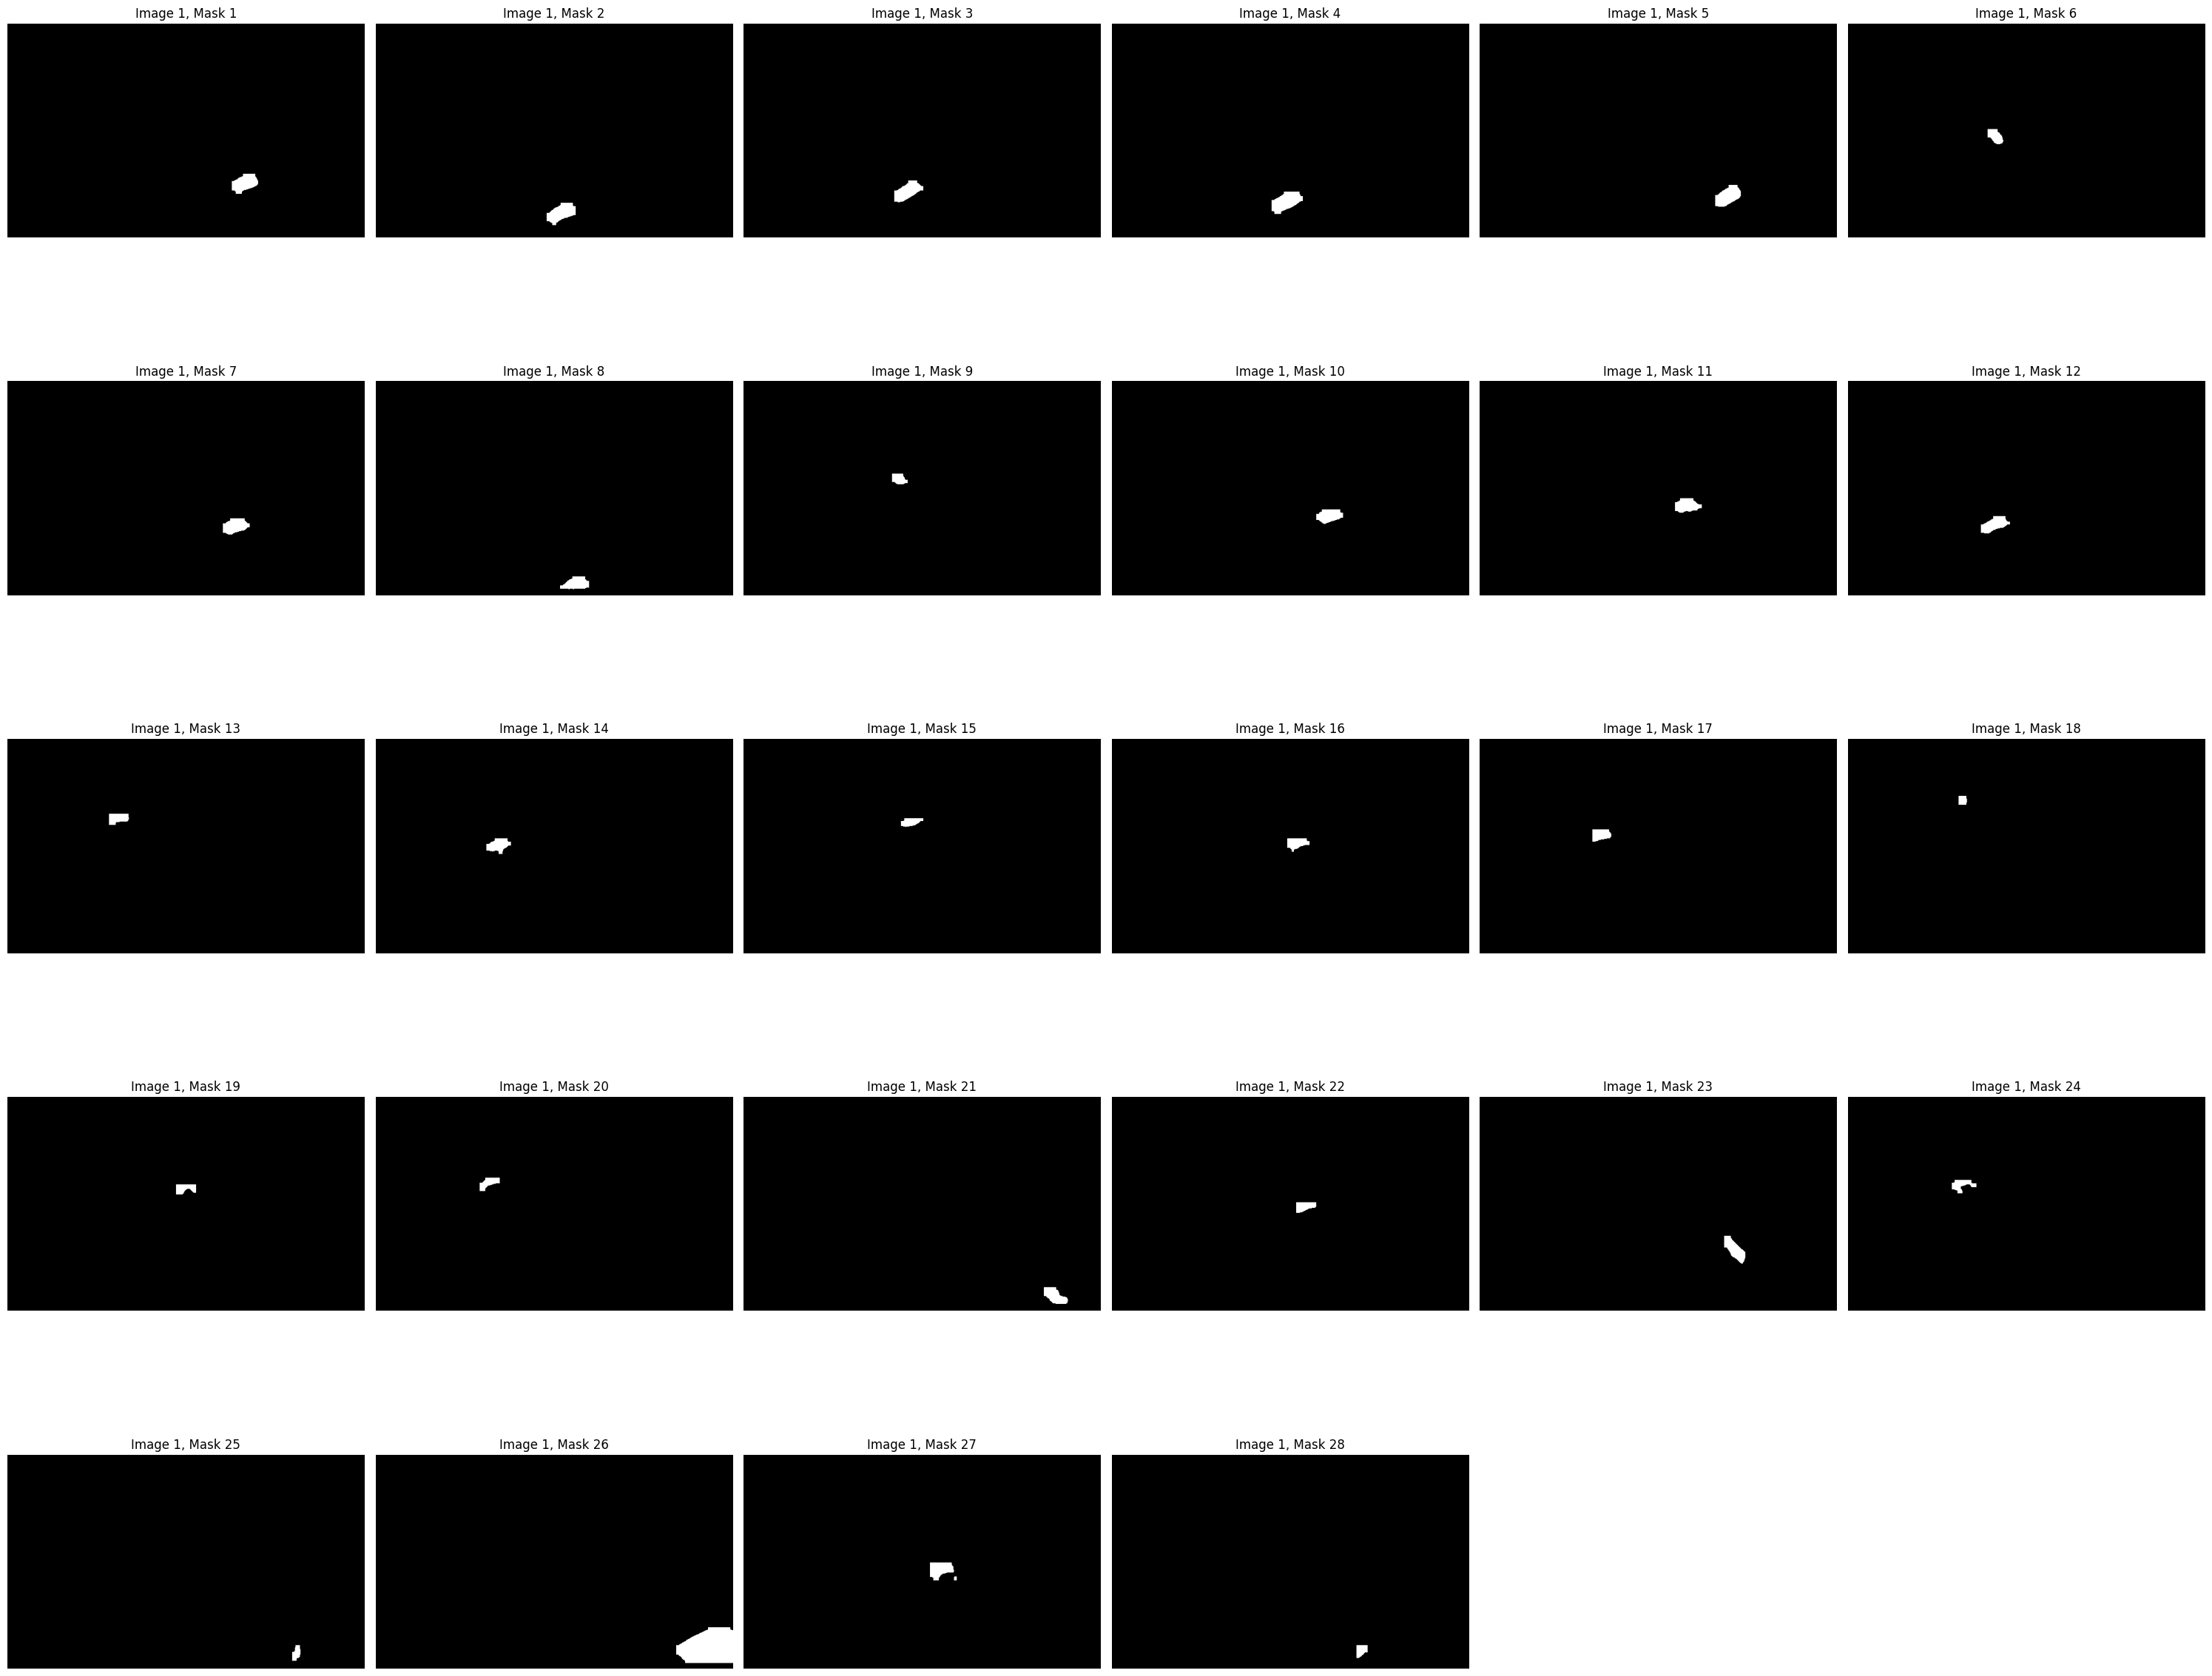

In [37]:
visualize_masks(results)

In [36]:
def visualize_masks(results):
    """Visualizes masks from the results of the post-processing function.

    Args:
        results: The output of your post-processing function.
    """
    if not isinstance(results, list) or len(results) != 3:
        raise TypeError("Results must be a list of length 3")

    results_objects = results[0]

    # Handle both single Results object and list of Results objects
    if isinstance(results_objects, list):
        results_objects_list = results_objects
    else:
        results_objects_list = [results_objects]  # Create a list if it's a single object

    for i, result_object in enumerate(results_objects_list):
        if result_object.masks is None:
            print(f"No masks for image {i+1}")
            continue

        masks = result_object.masks.data  # Access the underlying data
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()
        print(masks.shape)

        num_masks = masks.shape[0]
        if num_masks == 0:
            print(f"No masks found for image {i+1}")
            continue

        num_cols = int(np.ceil(np.sqrt(num_masks)))
        num_rows = int(np.ceil(num_masks / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
        axes = axes.flatten()

        for j in range(num_masks):
            mask = masks[j]
            if mask.ndim == 3 and mask.shape[0] in [3,4]: #If the mask is an image
                mask = np.transpose(mask, (1, 2, 0))
                mask = (mask - mask.min()) / (mask.max() - mask.min())
            elif mask.ndim == 2:
                pass
            else:
                raise ValueError("Masks must have 2 or 3 dimensions")

            axes[j].imshow(mask, cmap='gray' if mask.ndim==2 else None)
            axes[j].set_title(f"Image {i+1}, Mask {j+1}")
            axes[j].axis('off')

        for k in range(num_masks, num_rows * num_cols):
            fig.delaxes(axes[k])

        plt.tight_layout()
        plt.show()

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_heatmaps(heatmaps, cmap='viridis', interpolation='nearest', figsize_scale=4):
    """
    Visualizes a batch of heatmaps.

    Args:
        heatmaps (torch.Tensor): A tensor containing the heatmaps. 
                                 Expected shape (B, H, W) or (1, B, H, W), where B is the batch size.
        cmap (str, optional): The colormap to use. Defaults to 'viridis'.
        interpolation (str, optional): The interpolation method. Defaults to 'nearest'.
        figsize_scale (int, optional): Scaling factor for the figure size. Defaults to 4.
    """

    # Handle potential batch dimension of 1
    if heatmaps.ndim == 4 and heatmaps.shape[0] == 1:
        heatmaps = heatmaps.squeeze(0)
    elif heatmaps.ndim != 3:
        raise ValueError("Input tensor must have shape (B, H, W) or (1, B, H, W)")


    num_heatmaps = heatmaps.shape[0]
    num_cols = int(np.ceil(np.sqrt(num_heatmaps)))
    num_rows = int(np.ceil(num_heatmaps / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize_scale * num_cols, figsize_scale * num_rows))

    axes = axes.flatten()

    for i in range(num_heatmaps):
        heatmap = heatmaps[i].cpu().numpy() # Move to CPU if on GPU
        im = axes[i].imshow(heatmap, cmap=cmap, interpolation=interpolation)
        axes[i].set_title(f"Heatmap {i+1}")
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class YOLOPromptProcessor:
    def __init__(self, device, embedding_dim=768, output_dim=256, num_prototypes=32):  # Added num_prototypes
        self.device = device
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Linear(embedding_dim // 2, output_dim)
        ).to(device)
        self.output_dim = output_dim
        self.num_prototypes = num_prototypes # Store number of prototypes

    def process_prompts(self, pred, prompts, proto): # Added proto
        bs, num_boxes, _ = pred.shape
        nc = pred.shape[2] - 4 - self.num_prototypes
        box, cls, mask_coeffs = pred.split((4, nc, self.num_prototypes), 2)
        
        masks = (mask_coeffs @ proto.float().view(self.num_prototypes, -1)).view(bs,num_boxes, proto.shape[1], proto.shape[2])
        masks = masks.unsqueeze(2)
        object_embeddings = torch.mean(masks, dim=(3,4))
        object_embeddings = object_embeddings.expand(-1, -1, self.output_dim)

        results = []
        for b in range(bs):
            batch_results = []
            for prompt_type, prompt_data in prompts.items():
                if prompt_type == "text":
                    text_embeddings = self.mlp(prompt_data)
                    text_embeddings = text_embeddings.unsqueeze(0)
                    similarity = torch.bmm(object_embeddings[b].unsqueeze(0), text_embeddings.transpose(1, 2)).squeeze()
                    top_k_indices = torch.topk(similarity, min(prompt_data.shape[0], num_boxes)).indices
                    batch_results.append(object_embeddings[b][top_k_indices])
                elif prompt_type == "point":
                    idx = torch.zeros(num_boxes, dtype=torch.bool, device=self.device)
                    for point in prompt_data:
                        point_idx = torch.nonzero(masks[b, :, 0, point[1], point[0]], as_tuple=True)[0]
                        if len(point_idx):
                            idx[point_idx] = True
                    if idx.any():
                        batch_results.append(object_embeddings[b][idx])
                    else:
                        batch_results.append(torch.tensor([], device=self.device))
                elif prompt_type == "box":
                    boxes = xywh2xyxy(box[b])
                    idx = torch.zeros(num_boxes, dtype=torch.bool, device=self.device)
                    bbox_areas = (prompt_data[3] - prompt_data[1]) * (prompt_data[2] - prompt_data[0])
                    mask_areas = torch.stack([masks[b, i, 0, :, :].sum() for i in range(num_boxes)])
                    full_mask_areas = torch.sum(masks[b, :, 0, :, :], dim=(0,1))
                    union = bbox_areas + full_mask_areas - mask_areas
                    idx[torch.argmax(mask_areas / union)] = True
                    if idx.any():
                        batch_results.append(object_embeddings[b][idx])
                    else:
                        batch_results.append(torch.tensor([], device=self.device))
            results.append(batch_results)
        return results

processor = YOLOPromptProcessor(device, num_prototypes=num_prototypes)


results = processor.process_prompts(prediction, prompts, proto)

for batch_idx, batch_results in enumerate(results):
    print(f"Batch {batch_idx}:")
    for prompt_idx, prompt_result in enumerate(batch_results):
      if prompt_idx == 0:
        print(f"  Text Results: {prompt_result.shape if len(prompt_result) else None}")
      elif prompt_idx == 1:
        print(f"  Point Results: {prompt_result.shape if len(prompt_result) else None}")
      elif prompt_idx == 2:
        print(f"  Box Results: {prompt_result.shape if len(prompt_result) else None}")

In [ ]:

feature_maps = {"P3": P3, "P4": P4, "P5": P5, "Prototypes": Prototypes}

# Original image dimensions (Width, Height)
original_width, original_height = 1920, 1080


def extract_object_embedding_from_mask(feature_maps, mask):
    """
    Extracts an object embedding from multi-scale feature maps using a mask.

    Args:
        feature_maps: A list of feature maps [P3, P4, P5].
        mask: A binary mask (tensor) of shape (H, W) or (1, H, W) where 1 represents the object.

    Returns:
        A combined embedding vector or None if the mask is empty.
    """

    embeddings = []
    if mask.sum() == 0:  # Check if the mask is empty
        print("Empty Mask")
        return None

    if mask.ndim == 2:
        mask = mask.unsqueeze(0)

    for feature_map in feature_maps:
        _, _, h, w = feature_map.shape

        # Resize the mask to the current feature map's size
        resized_mask = F.interpolate(mask.unsqueeze(0).float(), size=(h, w), mode='nearest').squeeze(0).bool()

        # Apply the mask to the feature map
        masked_feature_map = feature_map * resized_mask

        # Spatial Pyramid Pooling
        pooled_features = []
        for pool_size in [1, 2, 4]:
            pooled = F.adaptive_avg_pool2d(masked_feature_map, pool_size)
            pooled_features.append(pooled.view(pooled.size(0), -1))
        spp_embedding = torch.cat(pooled_features, dim=1)
        embeddings.append(spp_embedding)

    combined_embedding = torch.cat(embeddings, dim=1)
    return combined_embedding


# Example mask (replace with your actual mask)
mask = torch.zeros((1, 512, 800), dtype=torch.bool)
mask[:, 100:200, 100:200] = True
mask = F.interpolate(mask.float().unsqueeze(0), size=(48, 80), mode='nearest').squeeze().bool()

# Extract embeddings
embedding = extract_object_embedding_from_mask(list(feature_maps.values()), mask)

if embedding is not None:
    print("Combined Embedding Shape:", embedding.shape)

# Example empty mask
empty_mask = torch.zeros((48, 80), dtype=torch.bool)
embedding = extract_object_embedding_from_mask(list(feature_maps.values()), empty_mask)

if embedding is not None:
    print("Combined Embedding Shape:", embedding.shape)

In [ ]:
import torch
import torch.nn.functional as F

# Example feature maps with different resolutions
P3 = torch.rand(1, 256, 48, 80)  # Shape: [Batch, Channels, Height, Width]
P4 = torch.rand(1, 256, 24, 40)
P5 = torch.rand(1, 512, 12, 20)
Prototypes = torch.rand(1, 32, 96, 160)  # Mask feature layer

feature_maps = {"P3": P3, "P4": P4, "P5": P5, "Prototypes": Prototypes}

# Example mask generated by Protonet (binary mask, 0 or 1)
mask = torch.randint(0, 2, (1, 1, 96, 160), dtype=torch.float32)  # Shape: [Batch, 1, Height, Width]

def scale_mask(mask, target_size):
    """
    Scale the mask to the size of the target feature map.
    """
    return F.interpolate(mask, size=target_size, mode='bilinear', align_corners=False)

def extract_roi_with_mask(feature_map, scaled_mask, output_size=(4, 4)):
    """
    Extract the masked region of interest from the feature map.
    """
    if scaled_mask.numel() == 0 or feature_map.numel() == 0:
        return None

    # Apply the mask to the feature map
    masked_feature_map = feature_map * scaled_mask

    # Perform RoI Align (interpolation) to a fixed size
    roi_aligned = F.interpolate(masked_feature_map, size=output_size, mode='bilinear', align_corners=False)
    return roi_aligned

def spp_pooling(roi_aligned, levels=[1, 2, 4]):
    """
    Apply Spatial Pyramid Pooling (SPP) to produce a fixed-size embedding.
    """
    if roi_aligned is None:
        return None  # Skip empty regions

    spp_features = []
    for level in levels:
        pool_size = (level, level)
        pooled = F.adaptive_avg_pool2d(roi_aligned, output_size=pool_size)
        spp_features.append(pooled.view(-1))  # Flatten each grid level

    return torch.cat(spp_features)  # Concatenate features

# Extract embeddings from all feature maps using mask
final_embeddings = []

for name, feature_map in feature_maps.items():
    # Scale mask to match the feature map size
    scaled_mask = scale_mask(mask, feature_map.shape[2:])  # Adjust height and width

    # Extract RoI using mask
    roi_aligned = extract_roi_with_mask(feature_map, scaled_mask, output_size=(4, 4))

    # Apply SPP to the masked RoI
    embedding = spp_pooling(roi_aligned, levels=[1, 2, 4])

    if embedding is not None:
        final_embeddings.append(embedding)

# Concatenate embeddings from all feature maps
if final_embeddings:
    final_embedding = torch.cat(final_embeddings, dim=0)  # Combined embedding
    print("Final Embedding Shape:", final_embedding.shape)
else:
    print("No valid embeddings were extracted.")


In [ ]:
def visualize_bounding_boxes(image_path, boxes):
    """Visualizes bounding boxes on an image.

    Args:
        image_path (str): Path to the image file.
        boxes (list or np.ndarray): Bounding boxes [x_min, y_min, x_max, y_max].
    """

    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
    except FileNotFoundError as e:
        print(e)
        return
    except Exception as e:
        print(f"Error reading image: {e}")
        return
    
    if not isinstance(boxes, (list, np.ndarray)):
        raise TypeError("Boxes must be a list or numpy array.")

    if isinstance(boxes, list):
        boxes = np.array(boxes)
    
    if boxes.size==0:
        print("No bounding boxes to draw.")
        return

    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box[:4])

        # Check if bounding box coordinates are within image boundaries
        x_min = max(0, min(x_min, img.shape[1] - 1))
        y_min = max(0, min(y_min, img.shape[0] - 1))
        x_max = max(0, min(x_max, img.shape[1] - 1))
        y_max = max(0, min(y_max, img.shape[0] - 1))

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cv2.imshow("Image with Bounding Boxes", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
img = results[0].img
bounding_box_data = [[1205.8362,  775.7701, 1345.6160,  873.3810],
        [ 923.1497,  928.0895, 1067.9541, 1041.0253],
        [ 805.0600,  814.2772,  959.5794,  929.0762],
        [ 857.6864,  864.1998, 1018.9708,  983.0920],
        [1262.8346,  838.2612, 1405.2760,  953.2280],
        [ 754.3951,  531.7988,  832.5991,  615.6710],
        [1156.3041,  707.5947, 1291.3114,  792.3053],
        [ 994.7120, 1010.7050, 1135.6857, 1080.0000],
        [ 794.8445,  457.0719,  869.1356,  521.1685],
        [1103.5140,  650.9929, 1232.8085,  734.5741],
        [1050.2720,  598.0719, 1180.9236,  674.8998],
        [ 713.7133,  688.9366,  858.5832,  783.0682],
        [ 544.6426,  364.9445,  650.3933,  417.8801],
        [ 599.7919,  496.1307,  713.3666,  572.7939],
        [ 850.0607,  384.1506,  953.5428,  437.6474],
        [ 943.0966,  494.8161, 1049.5039,  558.0393],
        [ 604.5488,  453.7618,  708.7924,  523.9070],
        [ 588.5543,  267.4215,  639.7720,  310.9883],
        [ 902.6401,  435.5471, 1003.6558,  496.4396],
        [ 557.4750,  404.7012,  656.9834,  464.9474],
        [1616.7374,  993.4770, 1740.5497, 1080.0000],
        [ 992.3569,  529.7488, 1095.5127,  593.1356],
        [1312.6978,  718.5173, 1428.5109,  866.1720],
        [ 559.5548,  409.9820,  678.6122,  471.3106],
        [1535.2305,  993.8024, 1574.9944, 1060.7910],
        [1615.5210,  888.6216, 1919.7212, 1079.3604],
        [1001.0233,  551.1833, 1137.4907,  631.2188],
        [1309.7262,  989.9487, 1365.0537, 1056.2626]]
visualize_bounding_boxes("drone.jpg" ,bounding_box_data)


In [ ]:
def visualize_masks_on_image(image, masks):
    """Visualizes binary masks on an RGB image, showing only masked regions.

    Args:
        image (np.ndarray or torch.Tensor): The RGB image of shape (H, W, 3) or (3, H, W) or (1,3,H,W).
        masks (torch.Tensor or ultralytics.engine.results.Masks): The masks of shape (N, H, W).
    """

    if isinstance(image, torch.Tensor):
        if image.ndim == 4 and image.shape[0] == 1:
            image = image.squeeze(0)  # Remove batch dimension if present
        if image.ndim == 3 and image.shape[0] == 3:
            image = image.permute(1, 2, 0) #Permute if shape is (C,H,W)
        image = image.cpu().numpy()
    elif not isinstance(image, np.ndarray) or image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Image must be a NumPy array of shape (H, W, 3) or torch tensor of (H,W,3) or (3,H,W) or (1,3,H,W)")

    if masks is None:
        print("No masks to visualize")
        return

    if isinstance(masks, torch.Tensor):
        masks = masks.cpu().numpy()
    else:
        raise TypeError("Masks must be a torch.Tensor or ultralytics.engine.results.Masks object.")

    num_masks = masks.shape[0]

    for i in range(num_masks):
        mask = masks[i]

        # Expand mask dimensions to match image channels (H, W) -> (H, W, 3)
        mask_expanded = np.expand_dims(mask, axis=-1)
        mask_expanded = np.repeat(mask_expanded, 3, axis=-1)

        # Apply mask to image
        masked_image = image * mask_expanded

        # Scale to 0-255 *BEFORE* converting to uint8 if image is float
        if image.dtype == np.float32 or image.dtype == np.float64:
            masked_image = (masked_image * 255).astype(np.uint8)
        else:
            masked_image = masked_image.astype(np.uint8)

        cv2.imshow(f"Mask {i+1} on Image", masked_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        
img = results[0].img
img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img.shape

masks = results[0].masks.data
masks.shape, type(masks)
visualize_masks_on_image(img, masks)